 # 读取水位文件

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pylab as mpl
sw = pd.read_csv('C:/Users/86137/Desktop/2rrr.csv') # 读取水位文件
training_set = sw.iloc[:73-15, 1:4].values  # "sw"中前6500行的第1到第10列数据提取出来作为训练集，存储到名为"training_set"的变量中
test_set = sw.iloc[73-15:73, 1:4].values  #  第6500行到第9369行的第1到第10列数据提取出来作为测试集，存储到名为"test_set"的变量中
sw

,index,times,rains,waterlevels
0,2023/7/10 21:00,710.21,0.000000,109.52
1,2023/7/10 20:00,710.20,0.000000,109.54
2,2023/7/10 19:00,710.19,0.000000,109.54
3,2023/7/10 18:00,710.18,0.000000,109.53
4,2023/7/10 17:00,710.17,0.000000,109.53
...,...,...,...,...
67,2023/7/8 2:00,708.02,0.000000,109.52
68,2023/7/8 1:00,708.01,0.000000,109.52
69,2023/7/8 0:00,708.00,0.011621,109.51
70,2023/7/7 23:00,707.23,0.014303,109.52


# 对数据样本进行归一化处理

In [2]:
x_train_set = training_set[:, 0:2].copy()  # 将第1列到第2列作为训练集的特征
y_train_set = training_set[:, 2:3].copy()    # 将第3列作为训练集的目标变量

x_test_set = test_set[:, 0:2].copy()        # 将第1列到第2列作为测试集的特征
y_test_set = test_set[:, 2:3].copy()          # 将第3列作为测试集的目标变量

yl_train = training_set[6:,1:2].copy()
yl_test = test_set[6:,1:2].copy()

#将数据归一化，范围是0到1
sc1 = MinMaxScaler(feature_range=(0, 1))  
# 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
x_train_set= sc1.fit_transform(x_train_set)  
 # 利用训练集的属性对测试集进行归一化
x_test_set = sc1.transform(x_test_set)  

#与上面一样
sc2 = MinMaxScaler(feature_range=(0, 1))  
y_train_set= sc2.fit_transform(y_train_set) 
y_test_set = sc2.transform(y_test_set) 


In [3]:
mpl.rcParams['font.sans-serif'] = 'simsun'# 设置字体为宋体
mpl.rcParams['axes.unicode_minus'] = False # 解决负号显示为方块的问题
plt.rcParams['figure.dpi'] =600 # 设置分辨率为600
plt.rcParams['figure.figsize'] = (12, 6.0) # 最后一行设置图像尺寸为12*6

In [4]:

x_train = []
y_train = []

x_test = []
y_test = []
# 测试集：csv表格中前（9369-2896=6500）天数据
# 利用for循环，遍历整个训练集，提取训练集中连续240天的数据作为输入特征x_train，第241天的数据作为标签，for循环共构建（9369-2896-240=6260）组数据。
for i in range(0, len(x_train_set)-6):
    x_train.append(x_train_set[i:i+6, 0:2])
    y_train.append(y_train_set[i+6])



# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape,y_train.shape)
# 将训练集的特征和标签转换为numpy数组，并打印出它们的形状
# 将测试集进行数据切割
for i in range(0, len(x_test_set)-6):
    x_test.append(x_test_set[i:i+6, 0:2])
    y_test.append(y_test_set[i+6])
# 最后一个元素作为该样本的标签，将它们分别添加到x_test和y_test列表中
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape,y_test.shape)

(52, 6, 2) (52, 1)
(8, 6, 2) (8, 1)


In [5]:
model = tf.keras.Sequential([
    LSTM(100,activation='tanh'),#一层RNN，100个节点，激活函数是tanh
    Dense(1)# 定义了一个Sequential模型，其中包含一个LSTM层和一个Dense层
])
# 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
model.compile(optimizer=tf.keras.optimizers.Adam(0.005),
              loss='mean_squared_error')  

checkpoint_save_path = "./checkpoint/LSTM_SW[2].ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)




-------------load the model-----------------


# 绘制预测图像/预测水位误差

In [6]:


cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')



history = model.fit(x_train, y_train, batch_size=8, epochs=10, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])
# history变量保存了模型训练的历史记录
model.summary()
# model.summary()函数用于打印模型的结构信息


Epoch 1/10
7/7 [==============================] - 3s 125ms/step - loss: 0.0769 - val_loss: 0.1393
Epoch 2/10
7/7 [==============================] - 0s 17ms/step - loss: 0.0801 - val_loss: 0.1338
Epoch 3/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0769 - val_loss: 0.1269
Epoch 4/10
7/7 [==============================] - 0s 16ms/step - loss: 0.0756 - val_loss: 0.1239
Epoch 5/10
7/7 [==============================] - 0s 9ms/step - loss: 0.0750 - val_loss: 0.1317
Epoch 6/10
7/7 [==============================] - 0s 12ms/step - loss: 0.0754 - val_loss: 0.1431
Epoch 7/10
7/7 [==============================] - 0s 14ms/step - loss: 0.0755 - val_loss: 0.1492
Epoch 8/10
7/7 [==============================] - 0s 12ms/step - loss: 0.0750 - val_loss: 0.1452
Epoch 9/10
7/7 [==============================] - 0s 14ms/step - loss: 0.0770 - val_loss: 0.1273
Epoch 10/10
7/7 [==============================] - 0s 10ms/step - loss: 0.0733 - val_loss: 0.1600
Model: "sequential"
_________

2/2 [==============================] - 0s 3ms/step


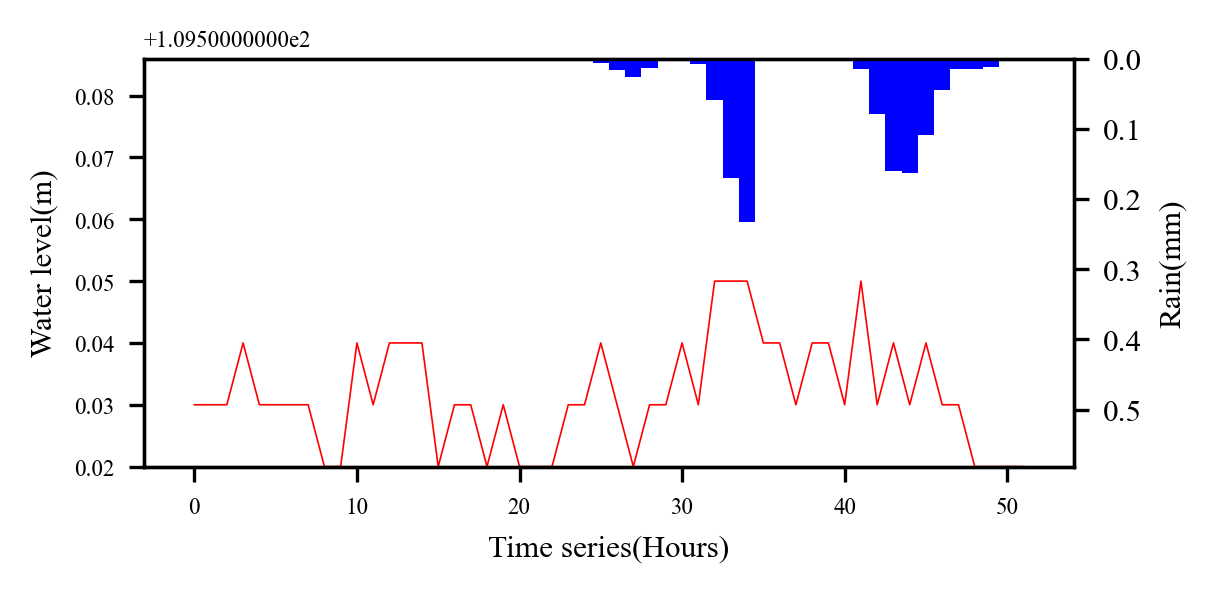

In [12]:
mpl.rcParams['font.sans-serif'] = 'Times New Roman'# font.sans-serif参数指定字体为Times New Roman
mpl.rcParams['font.size'] = 5.5# 参数指定字体大小为5.5
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['figure.dpi'] =300 # 绘图的分辨率为300
plt.rcParams['figure.figsize'] = (4,2.0) # figure.figsize参数指定绘图的大小为4x2.0


predicted_sw=model.predict(x_train)# model.predict()函数对训练集进行预测
predicted_sw=sc2.inverse_transform(predicted_sw)
real_sw = sc2.inverse_transform(y_train)# 反归一化操作 


positions=np.arange(len(yl_train))
fig, ax1 = plt.subplots() # 使用subplots()创建窗口
ax1.plot(real_sw, color='red', label='Water level',linewidth=0.4) 
#ax1.plot(predicted_sw, color='green',linestyle="--", label='预测水位')

if real_sw.min()<predicted_sw.min():# if语句判断真实值和预测值的最小值和最大值
    min=real_sw.min()# 较小的值赋给min变量
else:
    min=predicted_sw.min()
if real_sw.max()<predicted_sw.max():
    max=predicted_sw.max()
else:
    max=real_sw.max()
plt.ylim(min,min+(max-min)*2.2)# 使用plt.ylim()函数设置y轴范围

#plt.legend(loc=1, bbox_to_anchor=(0.28,1.15))

ax2 = ax1.twinx() # 创建第二个坐标轴
ax2.bar(positions,yl_train.flatten(),color='blue',label='Rain',width=1)
#plt.legend(loc=2, bbox_to_anchor=(0,1.1))
plt.yticks(fontsize=7.5)
plt.ylim(0,2.5*yl_train.max())
ax2.invert_yaxis()  #y轴反向


ax1.set_ylabel('Water level(m)',size=7.5)
ax2.set_ylabel('Rain(mm)',size=7.5)# set_ylabel()方法用于设置y轴标签
ax1.set_xlabel('Time series(Hours)',size=7.5)# set_xlabel()方法用于设置x轴标签
plt.subplots_adjust(bottom=0.2)# subplots_adjust()方法用于调整子图的位置
plt.savefig('data1.tiff')# savefig()方法用于保存图表
plt.show()# show()方法用于显示图表

1/1 [==============================] - 0s 20ms/step


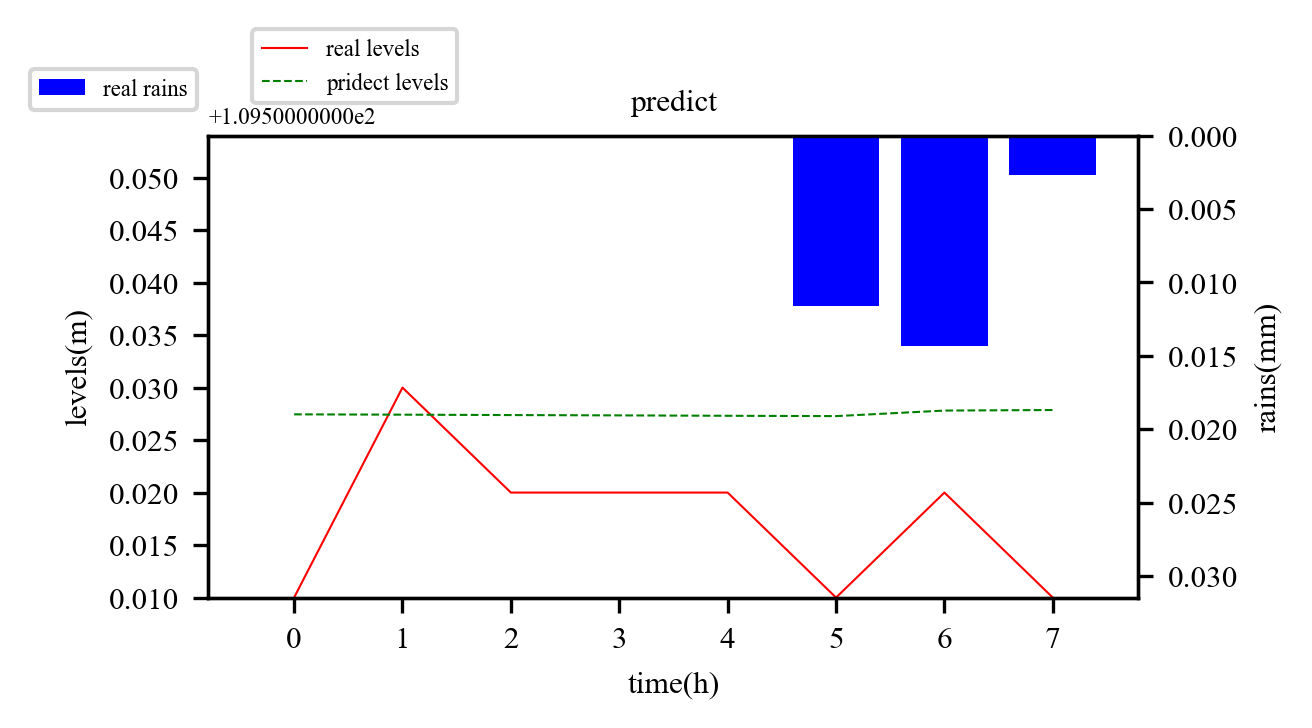

In [13]:
predicted_sw=model.predict(x_test)# 使用模型对测试数据进行预测，得到预测结果predicted_sw
predicted_sw=sc2.inverse_transform(predicted_sw)
real_sw = sc2.inverse_transform(y_test)#反归一化

positions=np.arange(len(yl_test))# np.arange()函数生成一个等差数列
fig, ax1 = plt.subplots() # 使用matplotlib库中的subplots()函数创建一个窗口
ax1.plot(real_sw, color='red', label='real levels',linewidth=0.5) 
ax1.plot(predicted_sw, color='green',linestyle="--", label='pridect levels',linewidth=0.5)
plt.xticks(fontsize=7.5)
plt.yticks(fontsize=7.5)# 使用fontsize参数设置字体大小

if real_sw.min()<predicted_sw.min():# if语句判断真实值和预测值的最小值和最大值
    min=real_sw.min()# 较小的值赋给min变量
else:
    min=predicted_sw.min()
if real_sw.max()<predicted_sw.max():
    max=predicted_sw.max()
else:
    max=real_sw.max()
plt.ylim(min,min+(max-min)*2.2)# 使用plt.ylim()函数设置y轴范围

plt.legend(loc=5, bbox_to_anchor=(0.28,1.15))
# 使用plt.legend()函数设置图例位置
ax2 = ax1.twinx() # 创建第二个坐标轴
ax2.bar(positions,yl_test.flatten(),color='blue',label='real rains')
plt.legend(loc=5, bbox_to_anchor=(0,1.1))
plt.yticks(fontsize=7.5)
plt.ylim(0,2.2*yl_test.max())
ax2.invert_yaxis()  #y轴反向

plt.title('predict',size=7.5)# plt.title()函数设置图表的标题，设置字体大小为7.5
ax1.set_ylabel('levels(m)',size=7.5)# ax.set_ylabel()函数设置y轴标签为"leves(m)"
ax2.set_ylabel('rains(mm)',size=7.5)# ax2.set_ylabel()函数设置另一个y轴标签为"rains(mm)"
ax1.set_xlabel('time(h)',size=7.5)# ax.set_xlabel()函数设置x轴标签为"time(h)"
plt.show()# plt.show()函数显示图表

In [14]:
# calculate MSE 均方误差 (预测值-真实值)^2 (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_sw, real_sw)
# calculate RMSE 均方根误差 sqrt[MSE] (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_sw, real_sw))
# calculate MAE 平均绝对误差 |预测值-真实值| (预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_sw, real_sw)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.000144
均方根误差: 0.012000
平均绝对误差: 0.010629


In [15]:
y_predicted=[]
x_test_predict=x_test[-7:].copy() #将倒数第-49小时的数据复制到x_test_predict中
for i in range(6):
    predicted_sw=model.predict(x_test_predict[i:i+1]) #对数据进行预测
    y_predicted.append(predicted_sw)#将预测数据保存到列表中
    for j in range(i):
        x_test_predict[i+1][-(j+1)][1]=y_predicted[-(j+1)]#使用保存下来的预测数据修改最近的i小时


y_predicted=np.array(y_predicted) #列表转化为数组
y_predicted=y_predicted.flatten() #3维数组变为1维
y_predicted=y_predicted.reshape(len(y_predicted),1) #将y_predicted变为合适反归一化的形状
y_predicted=sc2.inverse_transform(y_predicted)#反归一化

real_sw = sc2.inverse_transform(y_test[-6:])#反归一化
np.savetxt('LSTM_sw_predicted.txt', y_predicted, delimiter = ',')

1/1 [==============================] - 0s 24ms/step


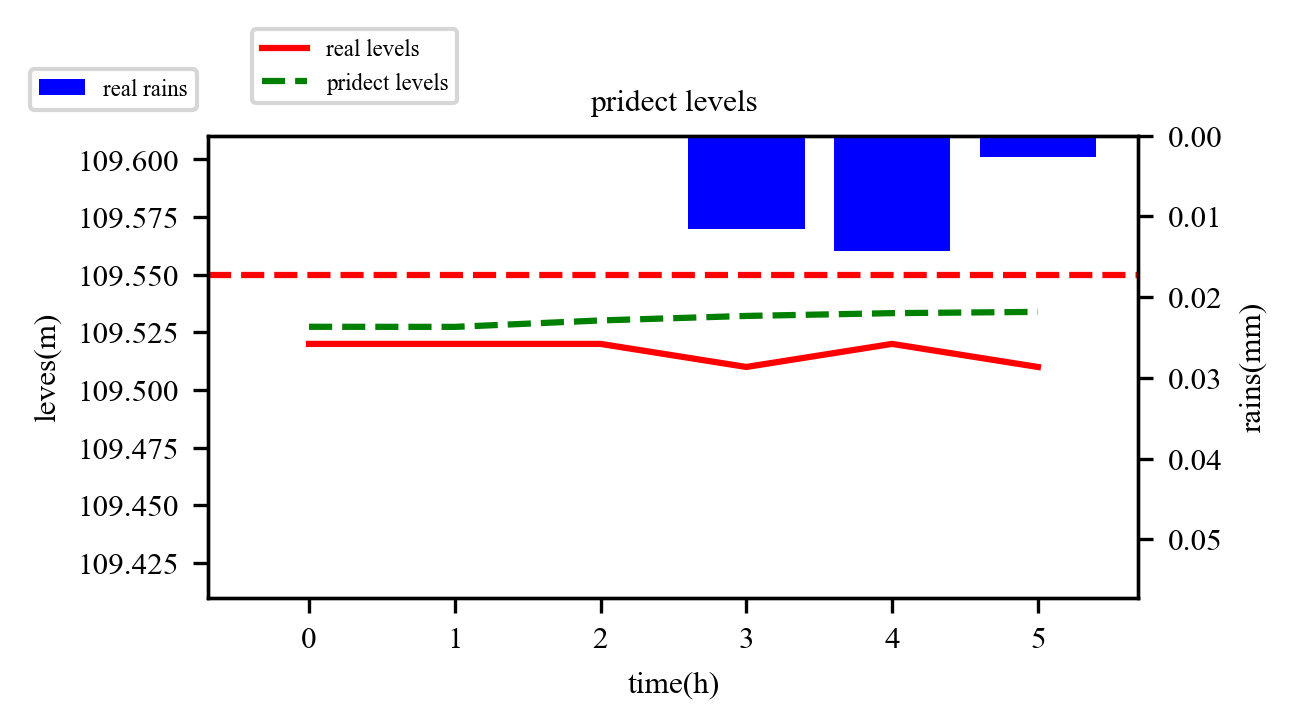

In [16]:

positions=np.arange(len(real_sw))

fig,ax = plt.subplots() # 使用subplots()创建窗口
if real_sw.min()<y_predicted.min():# if语句判断真实值和预测值的最小值和最大值
    
    min=real_sw.min()
else:
    min=y_predicted.min()
# 较小的值赋给min变量，较大的值赋给max变量    
if real_sw.max()<y_predicted.max():# 真实值的最大值小于预测值的最大值
    max=y_predicted.max()
else:
    max=real_sw.max()
ax.plot(positions,real_sw, color='red', label='real levels') #参数positions表示位置
ax.plot(positions,y_predicted, color='green',linestyle='--', label='pridect levels')
plt.xticks(fontsize=7.5)
plt.yticks(fontsize=7.5)# xticks()和yticks()方法用于设置x轴和y轴的刻度标签的字体大小
plt.legend(loc=5, bbox_to_anchor=(0.28,1.15))
plt.ylim(min-0.1,min+(max-min)*4.2)

ax.axhline(y=109.55, color='red', linestyle='--', label='forbidden line')
# average_level = np.mean(real_sw)
# ax.axhline(y=average_level * 1.1, color='red', linestyle='--', label='forbidden line')
ax2 = ax.twinx() # 创建第二个坐标轴
ax2.bar(positions,yl_test[-6:].flatten(),color='blue',label='real rains')
plt.legend(loc=5, bbox_to_anchor=(0,1.1))
plt.yticks(fontsize=7.5)
plt.ylim(0,4.0*yl_test.max())
ax2.invert_yaxis()  #y轴反向

plt.title('pridect levels',size=7.5)
ax.set_ylabel('leves(m)',size=7.5)
ax2.set_ylabel('rains(mm)',size=7.5)
ax.set_xlabel('time(h)',size=7.5)
plt.show()

In [21]:
# calculate MSE 均方误差 E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(y_predicted, real_sw)
# calculate RMSE 均方根误差 sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(y_predicted, real_sw))
# calculate MAE 平均绝对误差 E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(y_predicted, real_sw)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.000391
均方根误差: 0.019765
平均绝对误差: 0.018617
